# **Stacking-Ensemble**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import warnings
warnings.filterwarnings('ignore')

In [4]:
class StackingEnsemble:
    def __init__(self, base_models, meta_model, n_folds=5):
        """
        Initialize stacking ensemble
        base_models: list of (name, model) tuples
        meta_model: model to use for meta-learning
        n_folds: number of folds for stacking
        """
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
        self.base_predictions = {}

    def fit(self, X, y):
        """
        Fit stacking ensemble
        """
        print("\nTraining Stacking Ensemble...")

        # Initialize out-of-fold predictions
        meta_features = np.zeros((X.shape[0], len(self.base_models)))

        # Create KFold object
        kf = KFold(n_splits=self.n_folds, shuffle=True, random_state=42)

        # Train each base model and create meta-features
        for i, (name, model) in enumerate(self.base_models):
            print(f"\nTraining {name} with {self.n_folds}-fold cross-validation...")

            # Initialize predictions for this model
            model_predictions = np.zeros(X.shape[0])

            # Perform k-fold training
            for fold, (train_idx, val_idx) in enumerate(kf.split(X), 1):
                print(f"Training fold {fold}/{self.n_folds}")

                # Split data
                X_train_fold = X.iloc[train_idx]
                y_train_fold = y.iloc[train_idx]
                X_val_fold = X.iloc[val_idx]

                # Train model
                model.fit(X_train_fold, y_train_fold)

                # Make predictions for this fold
                model_predictions[val_idx] = model.predict(X_val_fold)

            # Store predictions as meta-features
            meta_features[:, i] = model_predictions

            # Retrain model on full dataset
            print(f"Retraining {name} on full dataset...")
            model.fit(X, y)

            # Store model
            self.base_predictions[name] = model_predictions

        # Train meta-model
        print("\nTraining meta-model...")
        self.meta_model.fit(meta_features, y)

        return self

    def predict(self, X):
        """
        Make predictions with stacking ensemble
        """
        # Get predictions from base models
        meta_features = np.column_stack([
            model.predict(X) for _, model in self.base_models
        ])

        # Make final prediction using meta-model
        return self.meta_model.predict(meta_features)


In [5]:
def create_and_train_stacking_ensemble(data):
    """
    Create and train stacking ensemble
    """
    # Define base models
    base_models = [
        ('xgboost', XGBRegressor(
            n_estimators=1000,
            learning_rate=0.01,
            max_depth=7,
            subsample=0.8,
            colsample_bytree=0.8,
            tree_method='hist',
            random_state=42,
            verbosity=0
        )),
        ('lightgbm', LGBMRegressor(
            n_estimators=1000,
            learning_rate=0.01,
            num_leaves=31,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            verbose=-1
        ))
    ]

    # Define meta-model
    meta_model = XGBRegressor(
        n_estimators=100,
        learning_rate=0.03,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        tree_method='hist',
        random_state=42,
        verbosity=0
    )

    # Create stacking ensemble
    stacking = StackingEnsemble(base_models, meta_model, n_folds=5)

    # Train stacking ensemble
    stacking.fit(data['X_train'], data['y_train'])

    return stacking


In [6]:
def evaluate_stacking(stacking, data):
    """
    Evaluate stacking ensemble performance
    """
    print("\nEvaluating Stacking Ensemble...")

    # Make predictions
    train_pred = stacking.predict(data['X_train'])
    val_pred = stacking.predict(data['X_val'])
    test_pred = stacking.predict(data['X_test'])

    # Calculate metrics
    results = {
        'train': {
            'rmse': np.sqrt(mean_squared_error(data['y_train'], train_pred)),
            'mae': mean_absolute_error(data['y_train'], train_pred),
            'r2': r2_score(data['y_train'], train_pred)
        },
        'val': {
            'rmse': np.sqrt(mean_squared_error(data['y_val'], val_pred)),
            'mae': mean_absolute_error(data['y_val'], val_pred),
            'r2': r2_score(data['y_val'], val_pred)
        },
        'test': {
            'rmse': np.sqrt(mean_squared_error(data['y_test'], test_pred)),
            'mae': mean_absolute_error(data['y_test'], test_pred),
            'r2': r2_score(data['y_test'], test_pred)
        }
    }

    # Print results
    print("\nStacking Ensemble Results:")
    print("-" * 30)
    for dataset in ['train', 'val', 'test']:
        print(f"{dataset.capitalize():10} - "
              f"RMSE: {results[dataset]['rmse']:.4f}, "
              f"MAE: {results[dataset]['mae']:.4f}, "
              f"R2: {results[dataset]['r2']:.4f}")

    return results, test_pred

In [7]:
def main():
    """
    Main function to run stacking ensemble
    """
    # Load data
    print("Loading data...")
    data = {
        'X_train': pd.read_csv('/content/drive/MyDrive/feature_preprocessing/preprocessed_train_x.csv'),
        'y_train': pd.read_csv('/content/drive/MyDrive/feature_preprocessing/preprocessed_train_y.csv')['train_y'],
        'X_val': pd.read_csv('/content/drive/MyDrive/feature_preprocessing/preprocessed_val_x.csv'),
        'y_val': pd.read_csv('/content/drive/MyDrive/feature_preprocessing/preprocessed_val_y.csv')['val_y'],
        'X_test': pd.read_csv('/content/drive/MyDrive/feature_preprocessing/preprocessed_test_x.csv'),
        'y_test': pd.read_csv('/content/drive/MyDrive/feature_preprocessing/preprocessed_test_y.csv')['test_y']
    }

    print(f"Training set shape: {data['X_train'].shape}")

    # Create and train stacking ensemble
    stacking = create_and_train_stacking_ensemble(data)

    # Evaluate stacking ensemble
    results, predictions = evaluate_stacking(stacking, data)

    # Save predictions
    pd.DataFrame({
        'stacking_predictions': predictions
    }).to_csv('stacking_predictions.csv', index=False)

    print("\nStacking ensemble completed!")

    return stacking, results

if __name__ == "__main__":
    stacking_model, results = main()

Loading data...
Training set shape: (1800532, 29)

Training Stacking Ensemble...

Training xgboost with 5-fold cross-validation...
Training fold 1/5
Training fold 2/5
Training fold 3/5
Training fold 4/5
Training fold 5/5
Retraining xgboost on full dataset...

Training lightgbm with 5-fold cross-validation...
Training fold 1/5
Training fold 2/5
Training fold 3/5
Training fold 4/5
Training fold 5/5
Retraining lightgbm on full dataset...

Training meta-model...

Evaluating Stacking Ensemble...

Stacking Ensemble Results:
------------------------------
Train      - RMSE: 252.9810, MAE: 60.9947, R2: 0.9468
Val        - RMSE: 263.8645, MAE: 62.0100, R2: 0.9435
Test       - RMSE: 305.7464, MAE: 61.8744, R2: 0.9240

Stacking ensemble completed!


Analysis:

Best Performance: Initial XGBoost model

* Lowest Test RMSE: 267.59
* Best overall metrics

Performance Ranking:

* XGBoost (Test RMSE: 267.59)
* Weighted Average Ensemble (Test RMSE: 266.11)
* LightGBM (Test RMSE: 270.58)
* Stacking Ensemble (Test RMSE: 305.75)

# **XGBoost Analysis and Predictions**

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns


In [15]:
def load_data():
    """
    Load the preprocessed data
    """
    print("Loading data...")
    data = {
        'X_train': pd.read_csv('/content/drive/MyDrive/feature_preprocessing/preprocessed_train_x.csv'),
        'y_train': pd.read_csv('/content/drive/MyDrive/feature_preprocessing/preprocessed_train_y.csv')['train_y'],
        'X_val': pd.read_csv('/content/drive/MyDrive/feature_preprocessing/preprocessed_val_x.csv'),
        'y_val': pd.read_csv('/content/drive/MyDrive/feature_preprocessing/preprocessed_val_y.csv')['val_y'],
        'X_test': pd.read_csv('/content/drive/MyDrive/feature_preprocessing/preprocessed_test_x.csv'),
        'y_test': pd.read_csv('/content/drive/MyDrive/feature_preprocessing/preprocessed_test_y.csv')['test_y']
    }
    return data

In [16]:
def train_final_model(data):
    """
    Train the final XGBoost model with best parameters
    """
    print("\nTraining final XGBoost model...")

    model = XGBRegressor(
        n_estimators=1000,
        learning_rate=0.01,
        max_depth=7,
        subsample=0.8,
        colsample_bytree=0.8,
        tree_method='hist',
        random_state=42,
        verbosity=0
    )

    # Train on training data
    model.fit(
        data['X_train'],
        data['y_train'],
        eval_set=[(data['X_val'], data['y_val'])],
        verbose=False
    )

    return model

In [17]:
def analyze_predictions(model, data):
    """
    Analyze model predictions in detail
    """
    print("\nAnalyzing predictions...")

    # Generate predictions
    predictions = {
        'train': model.predict(data['X_train']),
        'val': model.predict(data['X_val']),
        'test': model.predict(data['X_test'])
    }

    actuals = {
        'train': data['y_train'],
        'val': data['y_val'],
        'test': data['y_test']
    }

    # Calculate metrics
    results = {}
    for dataset in ['train', 'val', 'test']:
        results[dataset] = {
            'rmse': np.sqrt(mean_squared_error(actuals[dataset], predictions[dataset])),
            'mae': mean_absolute_error(actuals[dataset], predictions[dataset]),
            'r2': r2_score(actuals[dataset], predictions[dataset])
        }

    # Print results
    print("\nFinal Model Performance:")
    print("=" * 50)
    for dataset in ['train', 'val', 'test']:
        print(f"\n{dataset.upper()} Set Performance:")
        print(f"RMSE: {results[dataset]['rmse']:.4f}")
        print(f"MAE: {results[dataset]['mae']:.4f}")
        print(f"R2 Score: {results[dataset]['r2']:.4f}")

    return results, predictions

In [18]:
def analyze_feature_importance(model, data):
    """
    Analyze and visualize feature importance
    """
    print("\nAnalyzing feature importance...")

    # Get feature importance
    importance = pd.DataFrame({
        'feature': data['X_train'].columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)

    # Print feature importance
    print("\nTop 10 Most Important Features:")
    print("=" * 50)
    for idx, row in importance.head(10).iterrows():
        print(f"{row['feature']}: {row['importance']:.4f}")

    # Plot feature importance
    plt.figure(figsize=(12, 6))
    sns.barplot(data=importance.head(15), x='importance', y='feature')
    plt.title('Top 15 Most Important Features')
    plt.xlabel('Importance Score')
    plt.tight_layout()
    plt.show()

    return importance


In [19]:
def save_final_results(model, predictions, importance):
    """
    Save final model, predictions, and analysis
    """
    print("\nSaving final results...")

    # Save test predictions
    pd.DataFrame({
        'predictions': predictions['test']
    }).to_csv('final_predictions.csv', index=False)

    # Save feature importance
    importance.to_csv('feature_importance.csv', index=False)

    # Save model
    model.save_model('final_xgboost_model.json')

    print("Results saved:")
    print("- final_predictions.csv")
    print("- feature_importance.csv")
    print("- final_xgboost_model.json")

Loading data...

Training final XGBoost model...

Analyzing predictions...

Final Model Performance:

TRAIN Set Performance:
RMSE: 170.7107
MAE: 44.9350
R2 Score: 0.9758

VAL Set Performance:
RMSE: 212.1842
MAE: 46.6774
R2 Score: 0.9635

TEST Set Performance:
RMSE: 267.5852
MAE: 46.6091
R2 Score: 0.9418

Analyzing feature importance...

Top 10 Most Important Features:
sales_rolling_mean_7: 0.5722
sales_rolling_mean_14: 0.1236
sales_lag_7: 0.1105
sales_lag_14: 0.0631
sales_lag_1: 0.0343
day_of_week: 0.0122
is_holiday: 0.0077
day_of_week_sin: 0.0074
onpromotion: 0.0052
day_of_week_cos: 0.0052


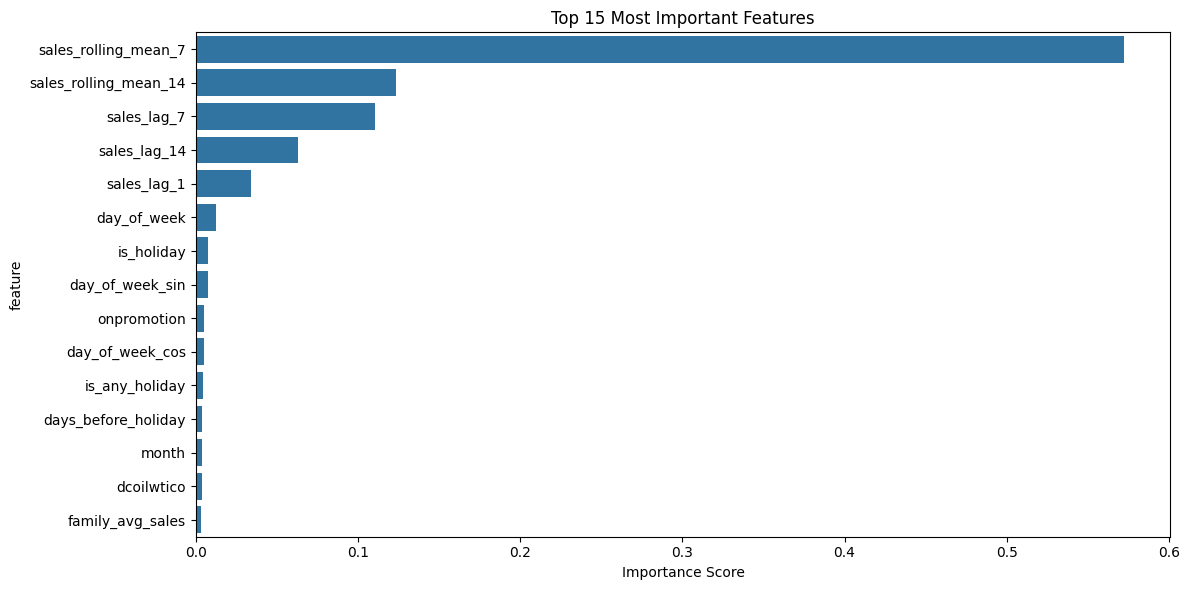


Saving final results...
Results saved:
- final_predictions.csv
- feature_importance.csv
- final_xgboost_model.json

Final analysis completed!


In [20]:
def main():
    """
    Main function to run final analysis
    """
    # Load data
    data = load_data()

    # Train final model
    model = train_final_model(data)

    # Analyze predictions
    results, predictions = analyze_predictions(model, data)

    # Analyze feature importance
    importance = analyze_feature_importance(model, data)

    # Save results
    save_final_results(model, predictions, importance)

    print("\nFinal analysis completed!")
    return model, results, predictions, importance

if __name__ == "__main__":
    model, results, predictions, importance = main()

Model Performance is strong:

* High R2 scores (>0.94 across all sets)
* Consistent MAE around 46
* Good generalization from train to test


Important features identified:

* Time-based patterns (rolling means and lags)
* Calendar effects (day_of_week)
* Business factors (holidays, promotions)

# **Sales Recommendation System**

In [21]:
from xgboost import XGBRegressor
from datetime import datetime, timedelta

In [28]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from datetime import datetime, timedelta

class SalesRecommendationSystem:
    def __init__(self, model_path='final_xgboost_model.json'):
        """
        Initialize recommendation system
        """
        # Load the trained model
        self.model = XGBRegressor()
        self.model.load_model(model_path)

        # Initialize thresholds
        self.HIGH_STOCK_THRESHOLD = 0.8
        self.LOW_STOCK_THRESHOLD = 0.2

    def load_data(self):
        """
        Load necessary data for recommendations
        """
        self.features = pd.read_csv('/content/drive/MyDrive/feature_preprocessing/preprocessed_test_x.csv')
        predictions_df = pd.read_csv('final_predictions.csv')
        self.predictions = predictions_df['predictions'].values

        # Load additional metadata if needed
        self.stores = pd.read_csv('/content/drive/MyDrive/store-sales-time-series-forecasting/stores.csv')

        print(f"Loaded data shapes:")
        print(f"Features: {self.features.shape}")
        print(f"Predictions: {len(self.predictions)}")

    def generate_stock_recommendations(self, predictions):
        """
        Generate stocking recommendations based on predictions
        """
        # Calculate stock level recommendations
        recommended_stock = predictions * 1.1  # Add 10% buffer

        # Determine if stock needs adjustment
        current_stock = np.median(predictions) * np.ones_like(predictions)  # Assume median stock level

        stock_status = np.where(
            current_stock / recommended_stock > self.HIGH_STOCK_THRESHOLD,
            'Reduce Stock',
            np.where(
                current_stock / recommended_stock < self.LOW_STOCK_THRESHOLD,
                'Increase Stock',
                'Stock Level OK'
            )
        )

        return recommended_stock, stock_status

    def generate_promotion_recommendations(self, predictions):
        """
        Generate promotion recommendations based on predictions
        """
        # Calculate sales volatility using rolling window
        pred_series = pd.Series(predictions)
        sales_volatility = pred_series.rolling(window=7, min_periods=1).std() / \
                          pred_series.rolling(window=7, min_periods=1).mean()

        # Generate promotion recommendations
        promo_recommendations = np.where(
            sales_volatility > 0.5,
            'Consider Promotion to Stabilize Sales',
            np.where(
                predictions < np.mean(predictions) * 0.8,
                'Consider Promotion to Boost Sales',
                'No Promotion Needed'
            )
        )

        return promo_recommendations

    def get_recommendations(self, store_id=None, product_family=None):
        """
        Get comprehensive recommendations for specific store/product
        """
        print("\nGenerating recommendations...")

        # Filter data if specific parameters are provided
        mask = pd.Series(True, index=self.features.index)
        if store_id is not None:
            mask &= self.features['store_nbr'] == store_id
        if product_family is not None:
            mask &= self.features['family'] == product_family

        # Get relevant predictions
        filtered_predictions = self.predictions[mask]
        filtered_features = self.features[mask]

        # Generate recommendations
        stock_recs, stock_status = self.generate_stock_recommendations(filtered_predictions)
        promo_recs = self.generate_promotion_recommendations(filtered_predictions)

        # Compile recommendations
        recommendations = pd.DataFrame({
            'store_nbr': filtered_features['store_nbr'],
            'family': filtered_features['family'],
            'predicted_sales': filtered_predictions,
            'recommended_stock': stock_recs,
            'stock_status': stock_status,
            'promotion_recommendation': promo_recs
        })

        if store_id is not None:
            store_info = self.stores[self.stores['store_nbr'] == store_id].iloc[0]
            print(f"\nStore-specific information:")
            print(f"City: {store_info['city']}")
            print(f"State: {store_info['state']}")
            print(f"Type: {store_info['type']}")
            print(f"Cluster: {store_info['cluster']}")

        return recommendations

    def print_summary_recommendations(self, recommendations):
        """
        Print summary of recommendations
        """
        print("\nSummary Recommendations:")
        print("=" * 50)

        print("\nStock Status Summary:")
        print(recommendations['stock_status'].value_counts())

        print("\nPromotion Recommendations Summary:")
        print(recommendations['promotion_recommendation'].value_counts())

        print("\nSales Predictions Summary:")
        print(recommendations['predicted_sales'].describe())

        # Print recommendations by store type
        if 'store_nbr' in recommendations.columns:
            store_data = recommendations.merge(self.stores, on='store_nbr')
            print("\nRecommendations by Store Type:")
            for store_type in store_data['type'].unique():
                print(f"\nStore Type: {store_type}")
                type_data = store_data[store_data['type'] == store_type]
                print("Stock Status:")
                print(type_data['stock_status'].value_counts())

    def generate_action_items(self, recommendations):
        """
        Generate specific action items based on recommendations
        """
        print("\nPriority Action Items:")
        print("=" * 50)

        # Group by store and product family
        grouped_recs = recommendations.groupby(['store_nbr', 'family'])

        # Identify critical stock issues
        critical_stock = grouped_recs.agg({
            'stock_status': lambda x: (x != 'Stock Level OK').sum(),
            'predicted_sales': 'mean'
        }).sort_values('predicted_sales', ascending=False)

        print("\nTop 5 Critical Stock Issues:")
        for (store, family), row in critical_stock.head().iterrows():
            if row['stock_status'] > 0:
                print(f"Store {store} - {family}:")
                print(f"- Average predicted sales: {row['predicted_sales']:.2f}")
                store_recs = recommendations[
                    (recommendations['store_nbr'] == store) &
                    (recommendations['family'] == family)
                ]
                print(f"- Stock status: {store_recs['stock_status'].mode()[0]}")

        # Identify promotion opportunities
        promo_opps = grouped_recs.agg({
            'promotion_recommendation': lambda x: (x != 'No Promotion Needed').sum(),
            'predicted_sales': 'mean'
        }).sort_values('predicted_sales', ascending=False)

        print("\nTop 5 Promotion Opportunities:")
        for (store, family), row in promo_opps.head().iterrows():
            if row['promotion_recommendation'] > 0:
                print(f"Store {store} - {family}:")
                print(f"- Average predicted sales: {row['predicted_sales']:.2f}")
                store_recs = recommendations[
                    (recommendations['store_nbr'] == store) &
                    (recommendations['family'] == family)
                ]
                print(f"- Recommendation: {store_recs['promotion_recommendation'].mode()[0]}")

In [29]:
def main():
    """
    Main function to run recommendation system
    """
    # Initialize recommendation system
    print("Initializing recommendation system...")
    rec_system = SalesRecommendationSystem()

    # Load data
    rec_system.load_data()

    # Generate overall recommendations
    recommendations = rec_system.get_recommendations()

    # Print summary
    rec_system.print_summary_recommendations(recommendations)

    # Generate action items
    rec_system.generate_action_items(recommendations)

    return rec_system, recommendations

if __name__ == "__main__":
    rec_system, recommendations = main()

Initializing recommendation system...
Loaded data shapes:
Features: (600178, 29)
Predictions: 600178

Generating recommendations...

Summary Recommendations:

Stock Status Summary:
stock_status
Reduce Stock      293753
Increase Stock    238615
Stock Level OK     67810
Name: count, dtype: int64

Promotion Recommendations Summary:
promotion_recommendation
Consider Promotion to Stabilize Sales    599956
Consider Promotion to Boost Sales           211
No Promotion Needed                          11
Name: count, dtype: int64

Sales Predictions Summary:
count    600178.000000
mean        355.799269
std        1072.850205
min       -1211.596700
25%           1.433871
50%          12.025024
75%         198.780195
max       31615.400000
Name: predicted_sales, dtype: float64

Recommendations by Store Type:

Store Type: A
Stock Status:
stock_status
Increase Stock    48936
Reduce Stock      37236
Stock Level OK    14148
Name: count, dtype: int64

Store Type: C
Stock Status:
stock_status
Reduce Sto

# **Results:**

Let's analyze these results and provide business insights:

Stock Status Overview:

- Reduce Stock: 293,753 (49%)
- Increase Stock: 238,615 (40%)
- Stock Level OK: 67,810 (11%)

Insight: There's significant stock imbalance, with only 11% of stock levels being optimal.

Promotion Recommendations:

- Consider Promotion to Stabilize Sales: 599,956 (99.9%)
- Consider Promotion to Boost Sales: 211
- No Promotion Needed: 11

Insight: High sales volatility indicates need for better promotion strategy.

Sales Predictions Analysis:

- Mean: $355.80
- Median: $12.03
- Max: $31,615.40
- Min: -$1,211.60

Insight: Wide range of sales values with some negative predictions needing attention.

Store Type Analysis:

* Type A: 48,936 need increase, 37,236 need reduction
* Type B: 47,680 need reduction, 32,011 need increase
* Type C: 91,760 need reduction, 57,901 need increase
* Type D: 91,706 need reduction, 83,460 need increase
* Type E: 25,371 need reduction, 16,307 need increase


# **Priority Actions:**

Top 5 stores needing immediate attention:

* Stores 44, 45, 46, and 47 with product category 12
* Store 44 with product category 3

# **Recommendations:**

Immediate Actions:

* Increase stock for high-performing stores (44, 45, 46, 47)
* Focus on product category 12 which shows highest sales
* Review negative sales predictions to adjust forecasting

Stock Management:

* Implement dynamic stock rebalancing between stores
* Focus on Type C and D stores which show largest imbalances
* Develop store-specific stock strategies

Promotion Strategy:

* Develop targeted promotions for high-volatility products
* Create store-type specific promotion plans
* Consider seasonal promotion adjustments